In [1]:
import qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
import numpy as np
import itertools
import math
import random
import matplotlib.pyplot as plt

### Idea :
Each time a new sample arrived in the stream, the statistics $n(l_m)$ and $n_k(l_m)$ are classically updated.

With this quantum algorithm we can find the two attributes $X_a$ and $X_b$ that maximise the purity gain much faster than the classical method.

We create an oracle that target the greatest output of a proxy function that have the same maximum than the purity gain function and that is much simplier than the initiale purity gain function.

### Simple example

Let's take the following stream S as:

\begin{equation}
    S = \{ ([2,3,1,2,2,1,1,3],2),~([1,2,1,1,1,3,2,2],1),~([1,1,2,3,2,1,1,2],2),~([2,3,2,1,1,3,2,3],2),~([2,1,1,2,1,2,2,1],1) \}
\end{equation}

Given that each attribute does not have the same number of possible values, we need to set it. Here, we choose to represent the data $x^n$ with 8 attributes $X_i$ such as:

- $X_1=\{1,2\}$
- $X_2=\{1,2,3\}$
- $X_3=\{1,2\}$
- $X_4=\{1,2,3\}$
- $X_5=\{1,2\}$
- $X_6=\{1,2,3\}$
- $X_7=\{1,2\}$
- $X_8=\{1,2,3\}$

In [2]:
# Number of attribute per item
len_PG = 8

# Possible values that can take each attribute 
Xi = [[1,2],[1,2,3],[1,2],[1,2,3],[1,2],[1,2,3],[1,2],[1,2,3]]

# Possible value that can take the class 
y = [1,2]

# Initialisation of the stream
S = [ [[2,3,1,2,2,1,1,3],2], [[1,2,1,1,1,3,2,2],1], [[1,1,2,3,2,1,1,2],2], [[2,3,2,1,1,3,2,3],2], [[2,1,1,2,1,2,2,1],1] ]

# Initialisation of the n_ijk statistic
n_ij = {1:[2,3],2:[2,1,2],3:[3,2],4:[2,2,1],5:[3,2],6:[2,1,2],7:[2,3],8:[1,2,2]} 

# Initialisation of the n_ijk statistic
n_ijk = {1:{1:[1,1],2:[1,2]},2:{1:[1,1],2:[1,0],3:[0,2]},3:{1:[2,1],2:[0,2]},4:{1:[1,1],2:[1,1],3:[0,1]},5:{1:[2,1],2:[0,2]},6:{1:[0,2],2:[1,0],3:[1,1]},7:{1:[0,2],2:[2,1]},8:{1:[1,0],2:[1,1],3:[0,2]}}

### For each new sample arriving in the stream we need to udpate the statistic $n_{ijk}(l_m)$ :

### Creation of a new sample in the stream

In [3]:
new_sample_x = []
for i in range(8):
    new_sample_x.append(random.choice(Xi[i]))
new_sample_y = random.choice(y)
S.append([new_sample_x,new_sample_y])
print('new_sample_x :',new_sample_x)
print('new_sample_y :',new_sample_y)
print('S:',S)

new_sample_x : [1, 3, 2, 3, 1, 2, 1, 1]
new_sample_y : 1
S: [[[2, 3, 1, 2, 2, 1, 1, 3], 2], [[1, 2, 1, 1, 1, 3, 2, 2], 1], [[1, 1, 2, 3, 2, 1, 1, 2], 2], [[2, 3, 2, 1, 1, 3, 2, 3], 2], [[2, 1, 1, 2, 1, 2, 2, 1], 1], [[1, 3, 2, 3, 1, 2, 1, 1], 1]]


### Update of the $n_{ij}$ statistic

In [4]:
c = 0
for i in range(len(n_ij)):
    for j in range(len(n_ij[i+1])):
        for ii in range(len(S)):
            if S[ii][0][i]==Xi[i][j]:
                c+=1
        n_ij[i+1][j]=c
        c = 0        
print('n_ij :',n_ij)

n_ij : {1: [3, 3], 2: [2, 1, 3], 3: [3, 3], 4: [2, 2, 2], 5: [4, 2], 6: [2, 2, 2], 7: [3, 3], 8: [2, 2, 2]}


### Update of the $n_{ijk}$ statistic

In [5]:
c = 0
for i in range(len(n_ijk)):
    for j in range(len(n_ijk[i+1])):
        for k in range(len(n_ijk[i+1][j+1])):
            for ii in range(len(S)):
                if S[ii][1]==y[k]:
                    if S[ii][0][i]==Xi[i][j]:
                        c+=1
            n_ijk[i+1][j+1][k]=c
            c = 0   
print('n_ijk :',n_ijk)

n_ijk : {1: {1: [2, 1], 2: [1, 2]}, 2: {1: [1, 1], 2: [1, 0], 3: [1, 2]}, 3: {1: [2, 1], 2: [1, 2]}, 4: {1: [1, 1], 2: [1, 1], 3: [1, 1]}, 5: {1: [3, 1], 2: [0, 2]}, 6: {1: [0, 2], 2: [2, 0], 3: [1, 1]}, 7: {1: [1, 2], 2: [2, 1]}, 8: {1: [2, 0], 2: [1, 1], 3: [0, 2]}}


### Define the initial purity gain function $G_{l_m}(X_i)$ and it proxy function

In [6]:
n_m = len(S) #Number of samples in the current leave l_m

In [7]:
def proxy_gain(i, n_m , n_ij , n_ijk, Xi, y ):
    G = 0
    for j in range(0, len(Xi[i])):
        for k in range(0, len(y)):
            if n_ijk[i+1][j+1][k]!=0:
                G += (n_ij[i+1][j] - n_ijk[i+1][j+1][k])              
    return int(G)

In [8]:
def gain(i, n_m , n_ij , n_ijk, Xi, y ):
    G = 0
    for j in range(0, len(Xi[i])):
        for k in range(0, len(y)):
            if n_ijk[i+1][j+1][k]!=0:
                G -= n_ijk[i+1][j+1][k] /n_m * np.log(n_ijk[i+1][j+1][k]/n_ij[i+1][j])             
    return G

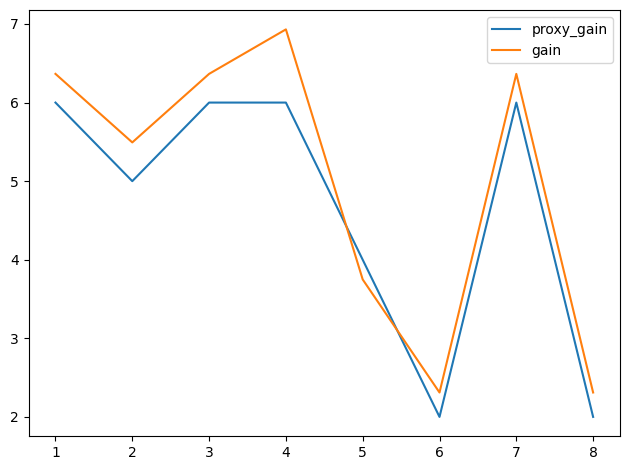

In [9]:
G1 = []
G2 = []
for i in range(8):
    G1.append(proxy_gain(i, n_m , n_ij , n_ijk, Xi, y ))
    G2.append(gain(i, n_m , n_ij , n_ijk, Xi, y )*10)
plt.figure()
i = [1,2,3,4,5,6,7,8]
plt.plot(i, G1, label='proxy_gain')
plt.plot(i, G2, label='gain')
plt.legend()
plt.tight_layout()
plt.show()

### Prepare input state

In [10]:
# Define the number of qubits
num_qubits = math.ceil(math.log2(len_PG))

# Create the data and ancilla registers
data = QuantumRegister(num_qubits, 'data')
cr = ClassicalRegister(num_qubits, 'classical')

# Create a quantum circuit 
qc = QuantumCircuit(data, cr)

# Create a uniform superposition
qc.h(range(num_qubits))
qc.barrier()

### Define Grover Operator

In [11]:
def oracle(num_qubits, len_PG):
    data = QuantumRegister(num_qubits, 'data')
    qc = QuantumCircuit(data, name='Oracle')

    oracle = np.identity(len_PG)

    for i in range(len_PG):
        if proxy_gain(i, n_m , n_ij , n_ijk, Xi, y ) >= 6:
            oracle[i][i] = -1

    qc.unitary(oracle, data)

    return qc

In [12]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits, name = 'Diffuser')
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)

    return qc

### Create Quantum Circuit

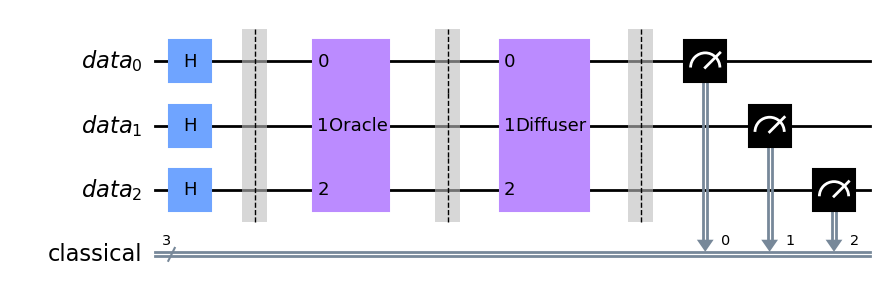

In [13]:
# Oracle
qc.append(oracle(num_qubits, len_PG), [*[i for i in range(num_qubits)]])
qc.barrier()

# Diffuser
qc.append(diffuser(num_qubits), [*[i for i in range(num_qubits)]])
qc.barrier()

# Measure of the ouputs
qc.measure(data, cr)

qc.draw(output='mpl')

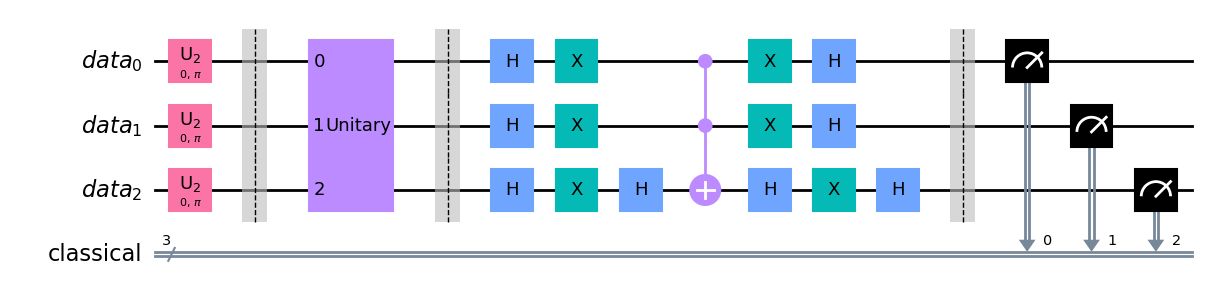

In [14]:
qc.decompose().draw(output='mpl')

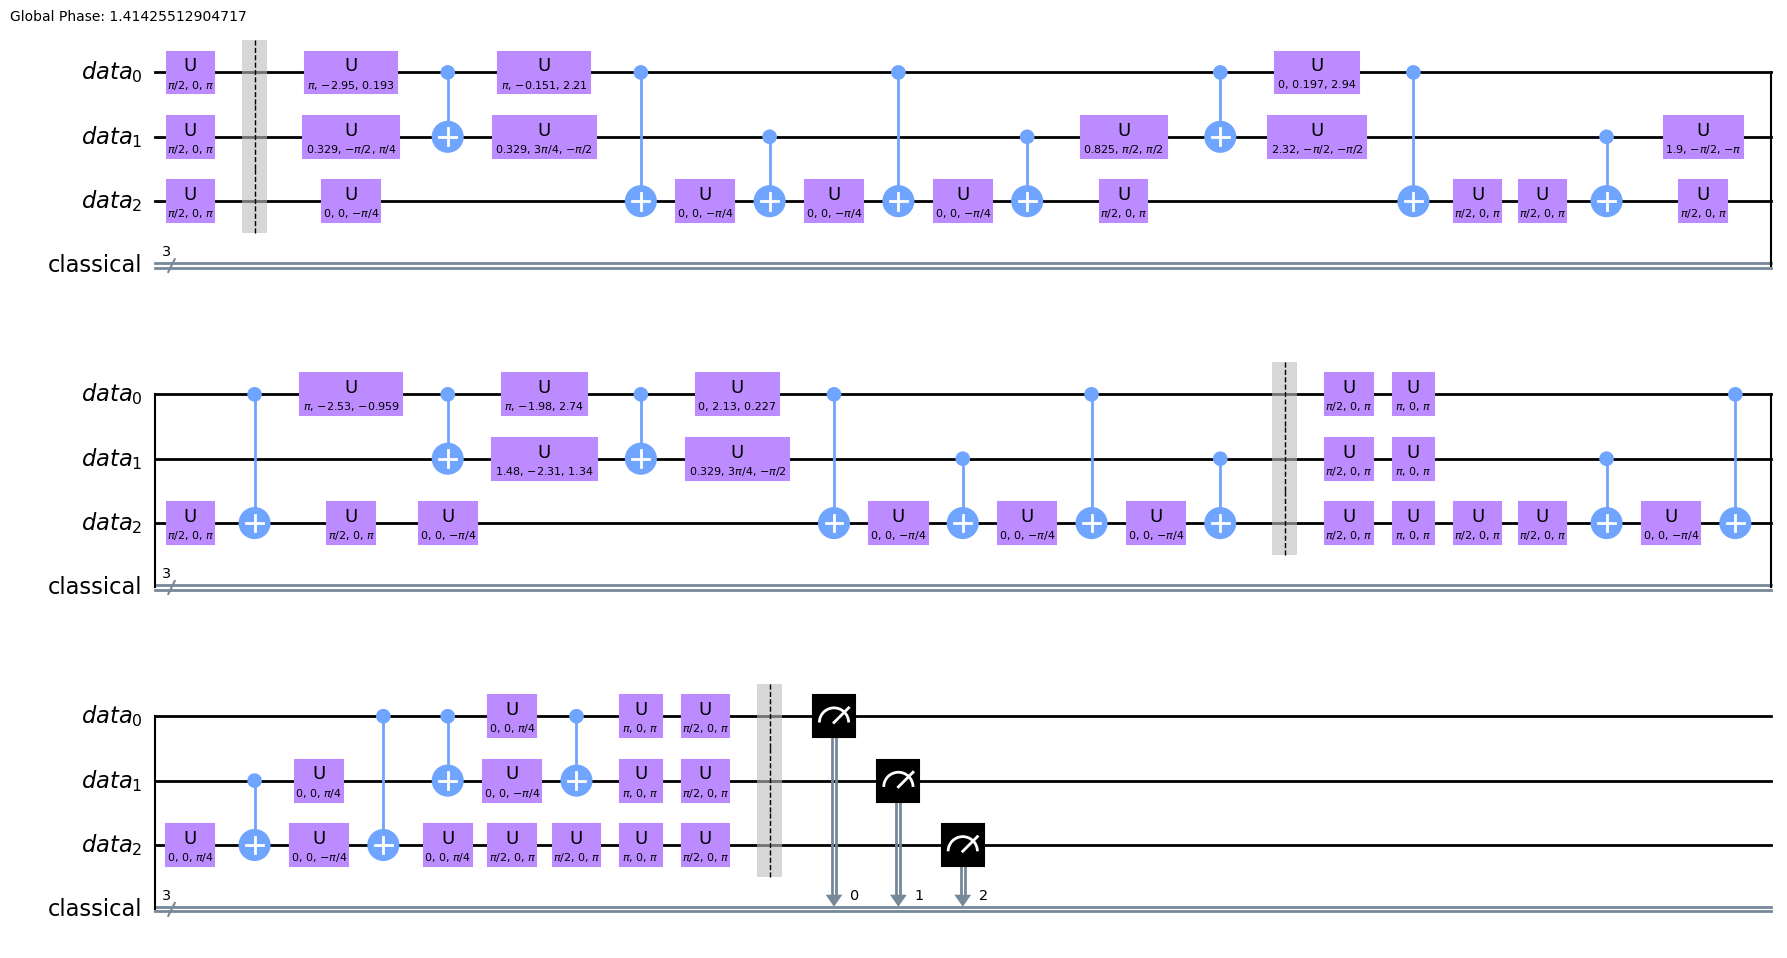

In [15]:
qc.decompose().decompose().decompose().decompose().decompose().draw(output='mpl')

In [16]:
print('Depth :',qc.decompose().decompose().depth())

Depth : 43


### Execute the Quantum Circuit

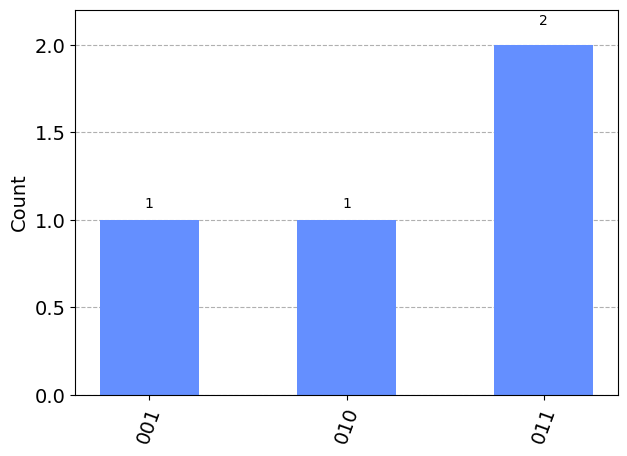

In [17]:
qasm = Aer.get_backend('qasm_simulator')
qc = qc.reverse_bits()
job = execute(qc, qasm, shots=4)
counts = job.result().get_counts()
plot_histogram(counts, bar_labels = True)

In [18]:
print(counts)

{'001': 1, '010': 1, '011': 2}


### QUANTUM : Calculate the difference beetwen the two highest values of purity gain $|G_{lm}(X_a)-G_{lm}(X_b)|$

In [19]:
first = int(list(counts.keys())[0],2)
if len(list(counts.keys()))>1:
        second = int(list(counts.keys())[1],2)
        hoeffding = abs(gain(first, n_m , n_ij , n_ijk, Xi, y )-gain(second, n_m , n_ij , n_ijk, Xi, y))

### CLASSIC : Calculate the difference beetwen the two highest values of purity gain $|G_{lm}(X_a)-G_{lm}(X_b)|$

In [20]:
PG_list = []
for i in range(len_PG):
    PG_list.append(gain(i, n_m , n_ij , n_ijk, Xi, y ))
max_index = PG_list.index(max(PG_list))
PG_list.remove(max(PG_list))
secon_max_index = PG_list.index(max(PG_list))
hoeffdingg = abs(gain(max_index, n_m , n_ij , n_ijk, Xi, y )-gain(secon_max_index+1, n_m , n_ij , n_ijk, Xi, y))

### Accuracy

In [21]:
same = 0
confidence = 0.05

for _ in range(100):
    
    # Number of features per item
    len_PG = 8
    
    # Possible values that can take each attribute 
    Xi = [[1,2],[1,2,3],[1,2],[1,2,3],[1,2],[1,2,3],[1,2],[1,2,3]]
    
    # Possible value that can take the class 
    y = [1,2]
    
    # Initialisation of the stream
    S = [ [[2,3,1,2,2,1,1,3],2], [[1,2,1,1,1,3,2,2],1], [[1,1,2,3,2,1,1,2],2], [[2,3,2,1,1,3,2,3],2], [[2,1,1,2,1,2,2,1],1] ]
    
    # Initialisation of the n_ijk statistic
    n_ij = {1:[2,3],2:[2,1,2],3:[3,2],4:[2,2,1],5:[3,2],6:[2,1,2],7:[2,3],8:[1,2,2]} 
    
    # Initialisation of the n_ijk statistic
    n_ijk = {1:{1:[1,1],2:[1,2]},2:{1:[1,1],2:[1,0],3:[0,2]},3:{1:[2,1],2:[0,2]},4:{1:[1,1],2:[1,1],3:[0,1]},5:{1:[2,1],2:[0,2]},6:{1:[0,2],2:[1,0],3:[1,1]},7:{1:[0,2],2:[2,1]},8:{1:[1,0],2:[1,1],3:[0,2]}}
    
    new_sample_x = []
    for i in range(8):
        new_sample_x.append(random.choice(Xi[i]))
    new_sample_y = random.choice(y)
    S.append([new_sample_x,new_sample_y])
    
    c = 0
    for i in range(len(n_ij)):
        for j in range(len(n_ij[i+1])):
            for ii in range(len(S)):
                if S[ii][0][i]==Xi[i][j]:
                    c+=1
            n_ij[i+1][j]=c
            c = 0        
    
    c = 0
    for i in range(len(n_ijk)):
        for j in range(len(n_ijk[i+1])):
            for k in range(len(n_ijk[i+1][j+1])):
                for ii in range(len(S)):
                    if S[ii][1]==y[k]:
                        if S[ii][0][i]==Xi[i][j]:
                            c+=1
                n_ijk[i+1][j+1][k]=c
                c = 0   
    
    n_m = len(S) #Number of samples in the current leave l_m
    def proxy_gain(i, n_m , n_ij , n_ijk, Xi, y ):
        G = 0
        for j in range(0, len(Xi[i])):
            for k in range(0, len(y)):
                if n_ijk[i+1][j+1][k]!=0:
                    G += (n_ij[i+1][j] - n_ijk[i+1][j+1][k])              
        return G
    
    def gain(i, n_m , n_ij , n_ijk, Xi, y ):
        G = 0
        for j in range(0, len(Xi[i])):
            for k in range(0, len(y)):
                if n_ijk[i+1][j+1][k]!=0:
                    G -= n_ijk[i+1][j+1][k] /n_m * np.log(n_ijk[i+1][j+1][k]/n_ij[i+1][j])
                               
        return G
    
    # Define the number of qubits
    num_qubits = math.ceil(math.log2(len_PG))
    
    # Create the data and ancilla registers
    data = QuantumRegister(num_qubits, 'data')
    cr = ClassicalRegister(num_qubits, 'classical')
    
    # Create a quantum circuit 
    qc = QuantumCircuit(data, cr)
    
    # Create a uniform superposition
    qc.h(range(num_qubits))
    qc.barrier()
    
    def oracle(num_qubits, len_PG):
        data = QuantumRegister(num_qubits, 'data')
        qc = QuantumCircuit(data)
    
        oracle = np.identity(len_PG)
    
        for i in range(len_PG):
            if proxy_gain(i, n_m , n_ij , n_ijk, Xi, y ) >= 6:
                oracle[i][i] = -1
    
        qc.unitary(oracle, data)
        
        return qc
    
    def diffuser(nqubits):
        qc = QuantumCircuit(nqubits)
        for qubit in range(nqubits):
            qc.h(qubit)
        for qubit in range(nqubits):
            qc.x(qubit)
        qc.h(nqubits - 1)
        qc.mct(list(range(nqubits - 1)), nqubits - 1)
        qc.h(nqubits - 1)
        for qubit in range(nqubits):
            qc.x(qubit)
        for qubit in range(nqubits):
            qc.h(qubit)
            
        U_s = qc.to_gate()
        U_s.name = "Diff"
        return U_s
    
    # Oracle
    qc.append(oracle(num_qubits, len_PG), [*[i for i in range(num_qubits)]])
    qc.barrier()
    
    # Diffuser
    qc.append(diffuser(num_qubits), [*[i for i in range(num_qubits)]])
    qc.barrier()
    
    # Measure of the ouputs
    qc.measure(data, cr)
    
    qasm = Aer.get_backend('qasm_simulator')
    qc = qc.reverse_bits()
    job = execute(qc, qasm, shots=4)
    counts = job.result().get_counts()
    first = int(list(counts.keys())[0],2)
    if len(list(counts.keys()))>1:
        second = int(list(counts.keys())[1],2)
        hoeffding = abs(gain(first, n_m , n_ij , n_ijk, Xi, y )-gain(second, n_m , n_ij , n_ijk, Xi, y ))

    PG_list = []
    for i in range(len_PG):
        PG_list.append(gain(i, n_m , n_ij , n_ijk, Xi, y ))
    max_index = PG_list.index(max(PG_list))
    PG_list.remove(max(PG_list))
    secon_max_index = PG_list.index(max(PG_list))
    hoeffdingg = abs(gain(max_index, n_m , n_ij , n_ijk, Xi, y )-gain(secon_max_index+1, n_m , n_ij , n_ijk, Xi, y ))

    if len(list(counts.keys()))>1:
        if hoeffding == hoeffdingg+confidence or hoeffding >= hoeffdingg-confidence:
        #if hoeffding == hoeffdingg:
            same+=1
        
print('Accuracy : ',same,'% with a confidence of',confidence)

Accuracy :  69 % with a confidence of 0.05
